# AutoML - Automated Machine Learning

In [ ]:
#Load the environment for the notebook from Project.toml and Manifest.toml

In [ ]:
]instantiate

Many public cloud providers have mature and extensive AutoML products in their portfolio - let's see how 3 biggest cloud platforms define the term:
* [**Amazon Sagemaker**](https://aws.amazon.com/machine-learning/automl/) - _"Automatic machine learning, known as AutoML, removes the tedious, iterative, and time-consuming work across the machine learning workflow from data acquisition to model operationalization, so you can spend less time on low level details and more time on using ML to improve business outcomes. AutoML tools take care of sourcing and preparing data, engineering features, training and tuning models, deploying models, and ongoing model monitoring and updating."_
* [**Azure Machine Learning**](https://learn.microsoft.com/en-us/azure/machine-learning/concept-automated-ml) - _"Automated machine learning, also referred to as automated ML or AutoML, is the process of automating the time-consuming, iterative tasks of machine learning model development. It allows data scientists, analysts, and developers to build ML models with high scale, efficiency, and productivity all while sustaining model quality."_
* [**Google Cloud AutoML**](https://cloud.google.com/automl) - _"AutoML enables developers with limited machine learning expertise to train high-quality models specific to their business needs. Build your own custom machine learning model in minutes."_

The descriptions are alike and focus on the following key ideas:
* removal of manual, repetetive work to enable rapid prototyping
* allowing users without in-depth Machine Learning expertise to build high-quality models
* easy deployment and monitoring of the trained models


<div>
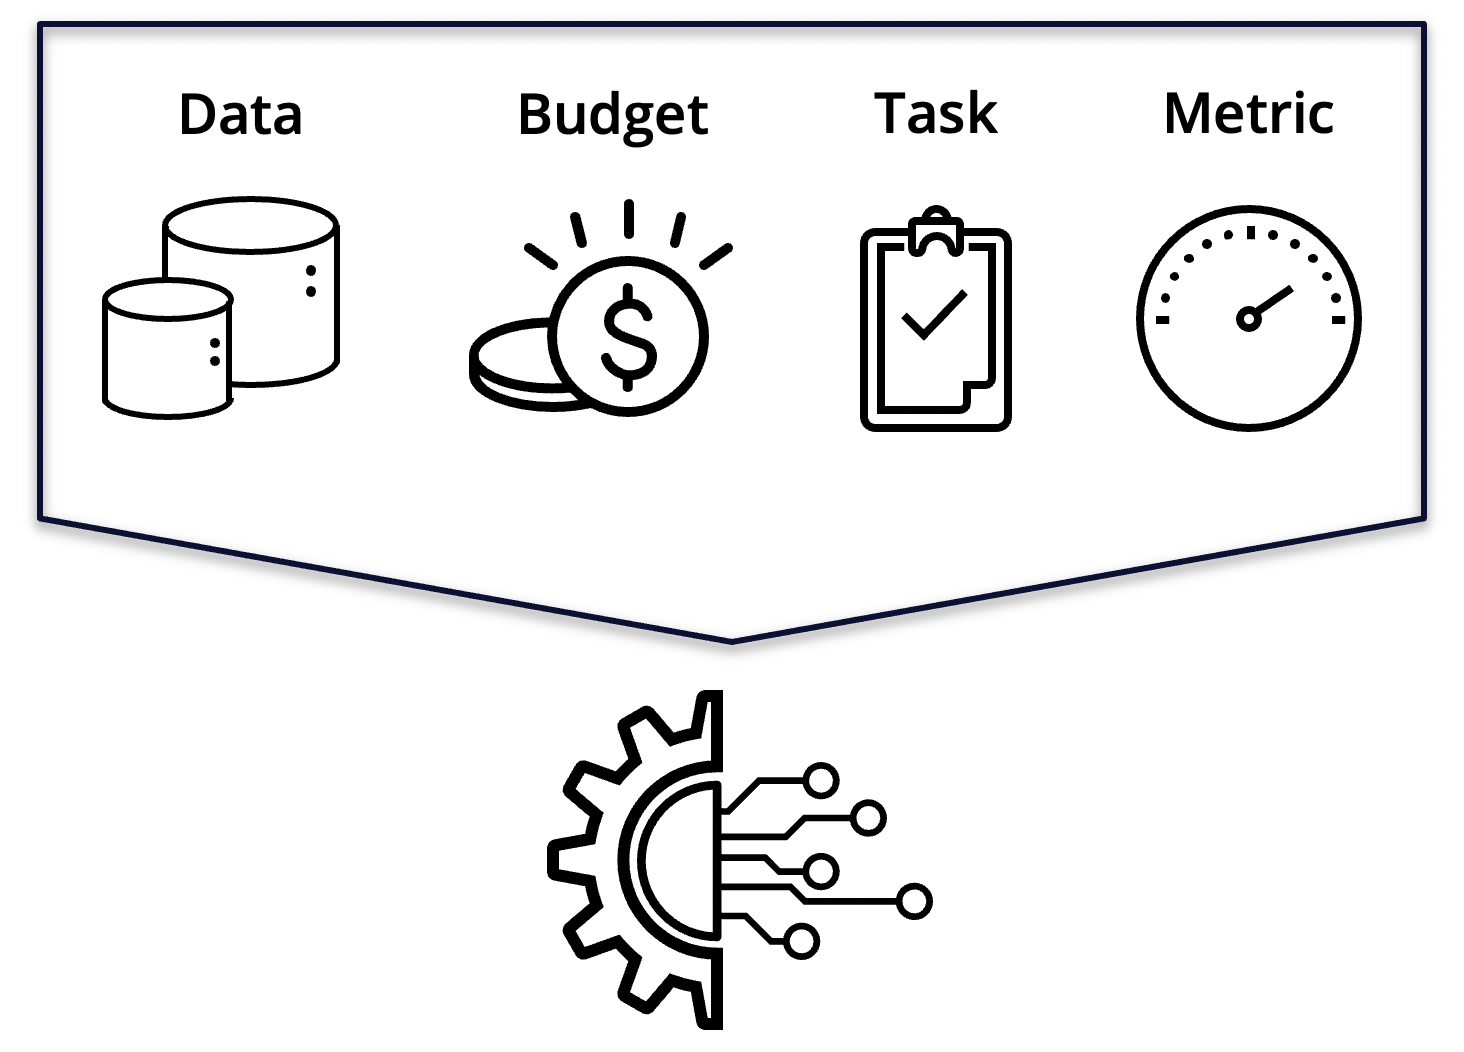
</div>


The AutoML frameworks require few inputs from the user:
1. **Data** - dataset to be used in the process (depending on the tool used the data may be tabular, set of images, text file or any other applicable)
2. **Budget** - usually time limit for processing or number of iterations of training (in cloud platforms it directly relates to actual spendings)
3. **Task** - what type of the model should be created e.g., regression, classification, image recognition (in particular cases it's implict by the used tool)
4. **Metric** - a measure used for assessing models' quality, for example RMSE for regression or F1-score for classification

After the setup, AutoML services/libraries handle multiple steps in the Machine Learning pipeline:
* data preprocessing and cleaning
* feature engineering
* training and hyperparameter tuning of multiple models
* model evaluation and reporting the models quality
* model deployment and serving

The degree of automation varies between the available solutions, but the main idea behind AutoML is to simplify the user's workflow. 

In [ ]:
using AutoMLPipeline
using CSV
using DataFrames
using Random
using Plots

We'll use the [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) data and predict if the client will subscribe to a term deposit (variable `y`). 

The dataset contains attributes related to:
* characteristics of the bank's client
* statistics from the ongoing and previous marketing campaigns
* social and economic indicators

Data preprocessing, model building and evaluation will be streamlined using [AutoMLPipeline.jl](https://github.com/IBM/AutoMLPipeline.jl).

In [ ]:
#Loading the Bank Marketing data
df = CSV.read("bank-additional-full.csv", DataFrame, delim=";");
#Removing the `duration` variable as it's highly related to the target (if duration=0, then y='no')
select!(df, Not(:duration));
#First 5 observations from the DataFrame
first(df, 5)

In [ ]:
#Splitting the dataset into a DataFrame with independent variables and Vector with target variable
X = df[:, begin:end-1]
y = df[:, end] |> Vector;

In [ ]:
#Preprocessing
#Categorical features selector
catf = CatFeatureSelector()
#Numerical features selector
numf = NumFeatureSelector()
#Numerical features will be changed to categorical if they have <= 8 unique values
disc = CatNumDiscriminator(Dict(:maxcategories => 8))
#One-hot encoding utility for categorical features
ohe = OneHotEncoder()
#Robust scaler for numerical features
rs = SKPreprocessor("RobustScaler");

In [ ]:
#Numerical features
first(fit_transform!(numf, X, y))

In [ ]:
#Categorical features
first(fit_transform!(catf, X, y))

In [ ]:
#`previous` column is treated as categorical as it has cardinality of 8
first(fit_transform!((@pipeline disc |> numf), X, y))

In [ ]:
combine(groupby(df, [:previous]), nrow => :count)

In [ ]:
#One-hot encoded categorical features
first(fit_transform!((@pipeline disc |> catf |> ohe), X, y))

In [ ]:
#Scaled numerical features
first(fit_transform!((@pipeline disc |> numf |> rs), X, y))

In [ ]:
#Preprocessing steps can be easily combined with model training
#Let's build pruned CART tree on the transformed dataset
pipe_tree = @pipeline disc |> ((catf |> ohe) + (numf |> rs)) |> PrunedTree();
fit!(pipe_tree, X, y)

In [ ]:
#Fitted pipeline can be used for prediction
AutoMLPipeline.transform!(pipe_tree, X)[begin:5]

In [ ]:
#Let's train multiple models and pick the best one according to accuracy metric in 5-fold cross-validation
jrf = RandomForest()
ada = SKLearner("AdaBoostClassifier")
mlp = SKLearner("MLPClassifier")
tree = PrunedTree()
lsvc = SKLearner("LinearSVC")

Random.seed!(1)
learners = DataFrame()
for learner in [jrf, ada, mlp, tree, lsvc]
  pipe = @pipeline disc |> ((catf |> ohe) + (numf |> rs)) |> learner
  println(learner.name)
  mean,sd,_ = crossvalidate(pipe, X, y, "accuracy_score", 5)
  global learners = vcat(learners, DataFrame(name=learner.name, mean=mean, sd=sd))
end

In [ ]:
@show sort(learners, :mean, rev=true);

In [ ]:
#Target variable is unbalanced, so let's use average of recall for both classes (balanced accuracy)
# as evaluation metric instead of accuracy
combine(groupby(df, [:y]), nrow => :count)

In [ ]:
Random.seed!(2)
learners = DataFrame()
for learner in [jrf, ada, mlp, tree, lsvc]
  pipe = @pipeline disc |> ((catf |> ohe) + (numf |> rs)) |> learner
  println(learner.name)
  mean, sd, _ = crossvalidate(pipe, X, y, "balanced_accuracy_score", 5)
  global learners = vcat(learners, DataFrame(name=learner.name, mean=mean, sd=sd))
end

In [ ]:
@show sort(learners, :mean, rev=true);

`AutoMLPipeline` is capable of building ensemble models - ML models created from multiple individual models:
* `VoteEnsemble` - individual models are trained on the input dataset in an ordinary fashion, during prediction each model produce an output, ensemble model counts the predicted values and provide the most common one as a final prediction
* `StackEnsemble` - individual models are trained on the subset of input data, after the training their output on the remaining part of the dataset is provided as input to the training process of the stacking model which generates a prediction for a whole ensemble

Ensemble models usually expose better predictive performance compared to their individual components. AutoML services (e.g., public cloud offerings) often combine ensemble models with automatic hyperparameter tuning - best models within the single class are mixed within ensemble to further boost the performance

In [ ]:
voting_ens = VoteEnsemble([ada, lsvc, mlp])
stack_ens = StackEnsemble([ada, lsvc, mlp], stacker = SKLearner("AdaBoostClassifier"));

In [ ]:
Random.seed!(2)
learners_ens = DataFrame()
for learner in [voting_ens, stack_ens]
  pipe = @pipeline disc |> ((catf |> ohe) + (numf |> rs)) |> learner
  println(learner.name)
  mean, sd, _ = crossvalidate(pipe, X, y, "balanced_accuracy_score", 5)
  global learners_ens = vcat(learners_ens, DataFrame(name=learner.name, mean=mean, sd=sd))
end

In [ ]:
@show learners_ens;

The evaluation procedure from `AutoMLPipeline` can also be utilized for hyperparameter tuning. 

We'll use grid search to tune AdaBoost with respect to:
* number of boosting iterations
* learning rate

Each combination of hyperparameters will be used to calculate balanced accuracy in 3-fold cross-validation (note, that the number of folds and the grid span should be higher, but we are limiting the values due to our 'time budget' constraint).

In [ ]:
adaboosts = []
ns = 50:10:100
lrs = 0.1:0.5:2.5
for n in ns
    for lr in lrs 
        push!(adaboosts, [n, lr, SKLearner("AdaBoostClassifier",Dict(:n_estimators=>n, :learning_rate=>lr))])
    end
end

In [ ]:
Random.seed!(42)
learners_ada = DataFrame()
for (n, lr, learner) in adaboosts
  pipe = @pipeline disc |> ((catf |> ohe) + (numf |> rs)) |> learner
  println(learner.name, n, lr)
  mean, sd, _ = crossvalidate(pipe, X, y, "balanced_accuracy_score", 3)
  global learners_ada = vcat(learners_ada, DataFrame(iterations=n, learning_rate=lr, mean=mean, sd=sd))
end

In [ ]:
@show learners_ada;

In [ ]:
#Best hyperparameters values
learners_ada[argmax(learners_ada.mean),:]

In [ ]:
heatmap(lrs, ns, Matrix(unstack(learners_ada, :iterations, :learning_rate, :mean))[:,2:end],
    ylabel="# iterations", xlabel="Learning rate",
    title="Balanced accuracy for AdaBoost classifier")